
# Support Vector Machine


## Initialization: courtesy of Tove

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SequentialFeatureSelector  # RFE only works for linear SVM
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, cohen_kappa_score


#plt.style.use("seaborn-v0_8-colorblind")
# The following lets us import cleanup.py
# Specifically it adds SF295_G007 to the python system path

from cleanup import removeRows
from SVM.model import svm_model


In [2]:
data_processor = removeRows("../project_train.csv", rows_to_remove=[69, 85, 95])  # speechiness has an "outlier" as in one datapoint far away from the rest
data_processor.process_rows();
data = data_processor.df


Row 69 will be removed:
danceability          0.715
energy                0.288
key                   1.000
loudness            -13.843
mode                  1.000
speechiness           0.925
acousticness          0.785
instrumentalness      0.000
liveness              0.688
valence               0.772
tempo               115.114
Label                 0.000
Name: 68, dtype: float64

Row 85 will be removed:
danceability         0.4080
energy               0.7140
key                  0.0000
loudness            -6.9420
mode                 1.0000
speechiness          0.0666
acousticness         0.0356
instrumentalness     0.0000
liveness             0.2580
valence              0.7600
tempo               75.3970
Label                1.0000
Name: 85, dtype: float64

Row 95 will be removed:
danceability         0.8060
energy               0.6080
key                  1.0000
loudness            -7.0080
mode                 1.0000
speechiness          0.0659
acousticness         0.0113
instrum

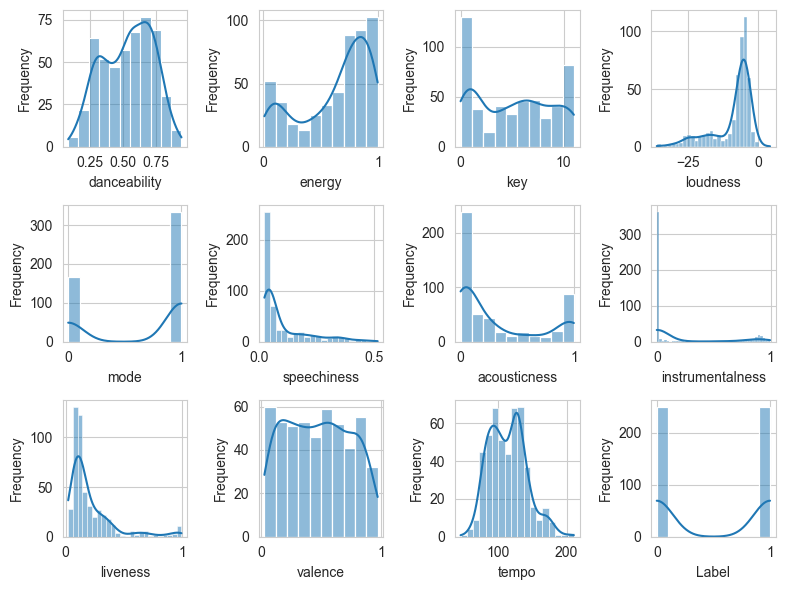

In [3]:
# Check distribution
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Create the pairplot with scatter plots for off-diagonal and probability distributions (KDE) on diagonal
#sns.pairplot(data, hue = "Label", diag_kws={'fill': False}, corner=True)

## Transforming data - courtesy of Tove

In [4]:
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

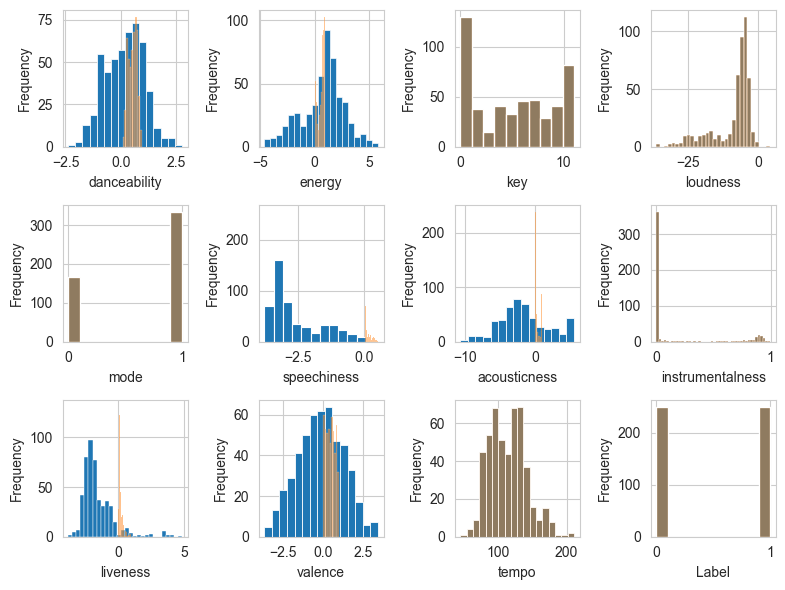

In [5]:
# Check distribution again, comparing transformed (blue) with initial (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(transformed_data[col], ax=axes[i],alpha=1)
    sns.histplot(data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#sns.pairplot(transformed_data[vars_to_transform + ["Label"]], hue = "Label", diag_kws={'fill': False})

In [6]:
scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)
#sns.pairplot(scaled_data[vars_to_transform + ["loudness", "tempo", "Label"]], hue = "Label", diag_kws={'fill': False})

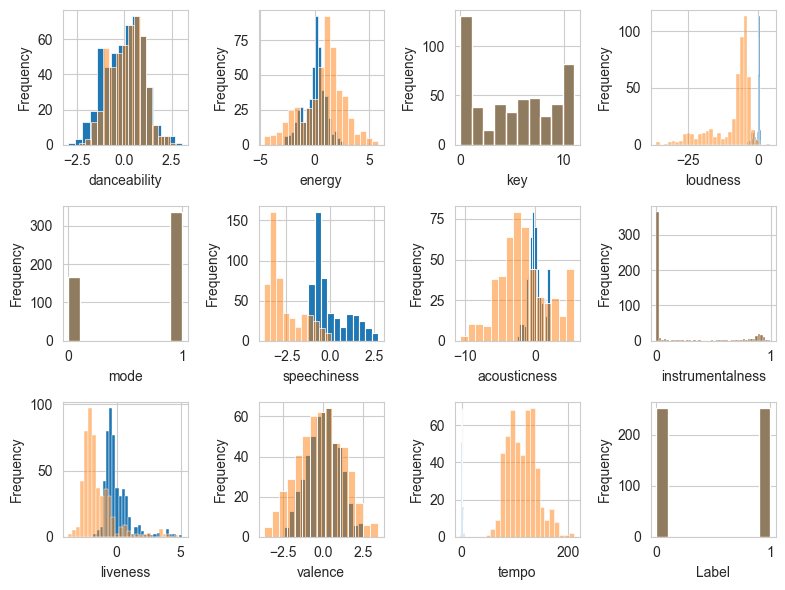

In [7]:
# Check distribution again, comparing scaled (blue) with transformed (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(scaled_data.columns):
    sns.histplot(scaled_data[col], ax=axes[i],alpha=1)
    sns.histplot(transformed_data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
all_predictors = scaled_data.drop([] + ["Label"], axis=1)
response = scaled_data["Label"]

# We drop_first because one of the variables in each of key,
# mode is determined by the values of the others
# (for example mode != 0 implies mode = 1)
encoded_data = pd.get_dummies(
    all_predictors, columns=["key", "mode"], drop_first=True
)

predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.2, random_state=8)

<Axes: >

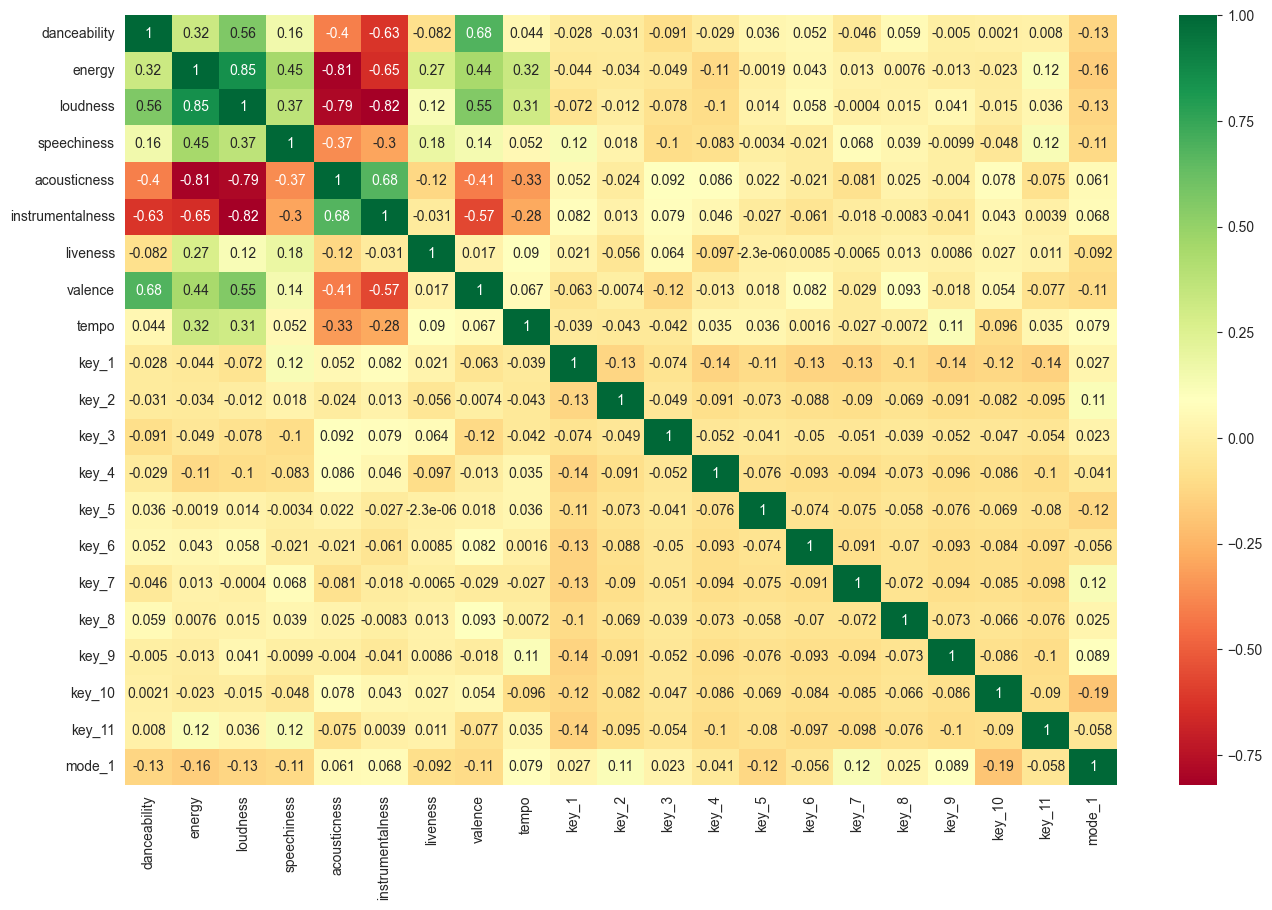

In [9]:
# heat map of correlation
plt.figure(figsize=(16,10))
sns.heatmap(predictors_train.corr(), annot=True, cmap='RdYlGn')

Loudness, acousticness, instrumentalness are probably redundant.

<Axes: >

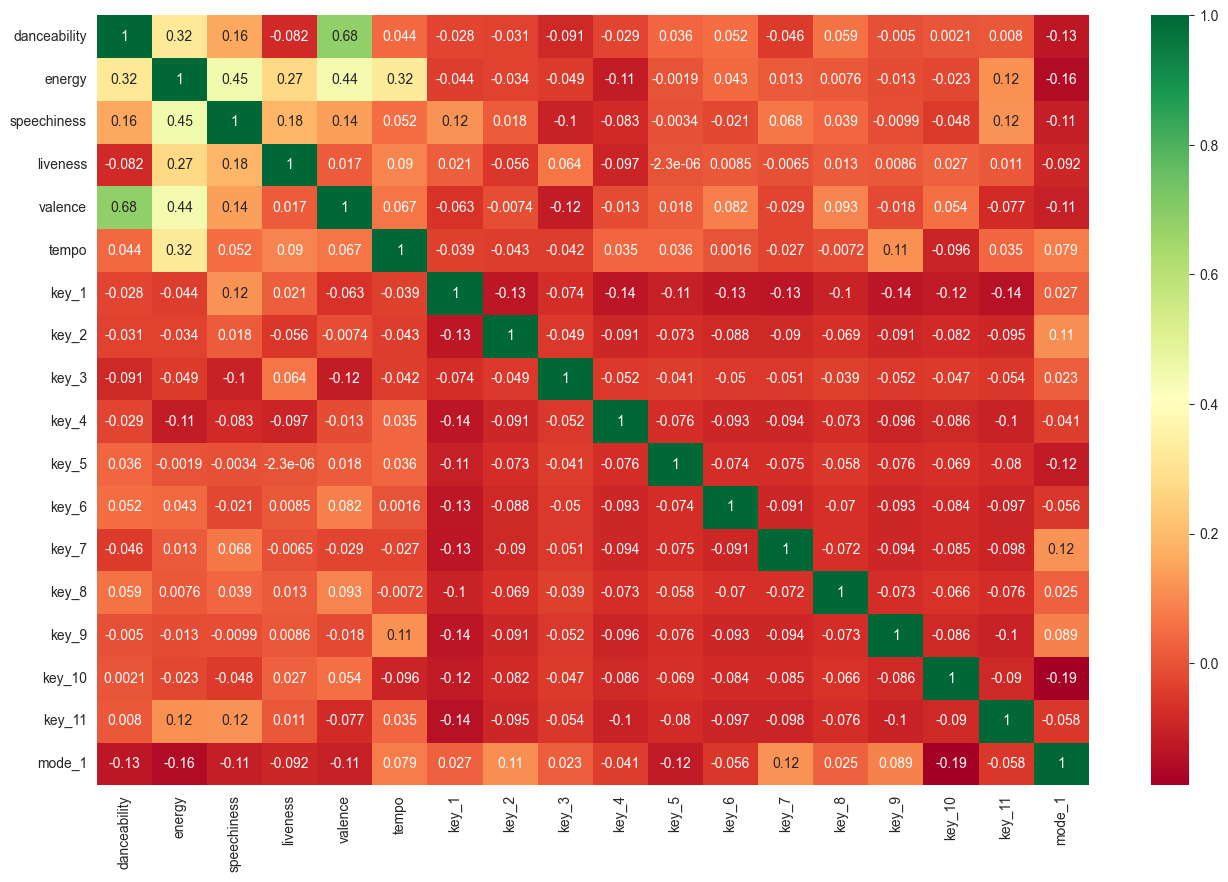

In [10]:
exclude = ['loudness', 'acousticness', 'instrumentalness']
predictors_train_mod = predictors_train.drop(columns=exclude)
plt.figure(figsize=(16, 10))
sns.heatmap(predictors_train_mod.corr(), annot=True, cmap='RdYlGn')

We can see valence is somewhat correlated to danceability, but the rest looks good to me.

In [11]:
predictors_train_mod, predictors_test_mod, response_train_mod, response_test_mod = train_test_split(encoded_data.drop(columns=exclude), response, test_size=0.2, random_state=8)

## Training the SVM
First, a linear SVM is tried

Accuracy: 80.20%
Precision: 87.80%
Recall: 70.59%
Cohen's Kappa Score: 0.60


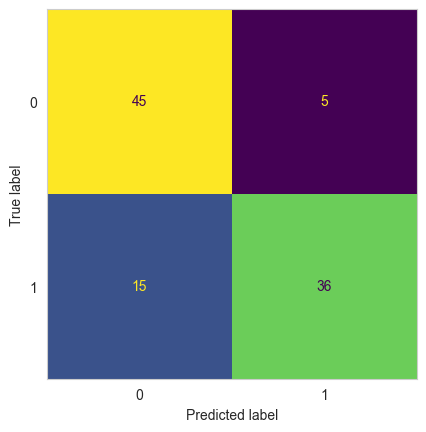

In [14]:
model, _ = svm_model('linear', predictors_train, response_train, predictors_test, response_test) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test, response_test, colorbar=False, cmap='viridis')
plt.grid(False)

Accuracy: 77.23%
Precision: 85.00%
Recall: 66.67%
Cohen's Kappa Score: 0.55


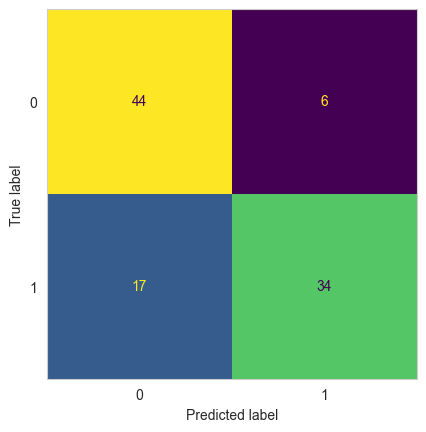

In [15]:
model, _ = svm_model('linear', predictors_train_mod, response_train_mod, predictors_test_mod, response_test_mod) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test_mod, response_test_mod, colorbar=False, cmap='viridis')
plt.grid(False)

#### Now, a non-linear SVM with rbf (radial basis function) kernel:

Accuracy: 84.16%
Precision: 88.89%
Recall: 78.43%
Cohen's Kappa Score: 0.68


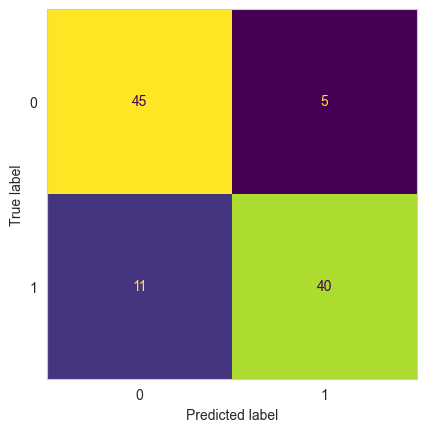

In [16]:
model, _ = svm_model('rbf', predictors_train, response_train, predictors_test, response_test) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test, response_test, colorbar=False, cmap='viridis')
plt.grid(False)

Accuracy: 83.17%
Precision: 86.96%
Recall: 78.43%
Cohen's Kappa Score: 0.66


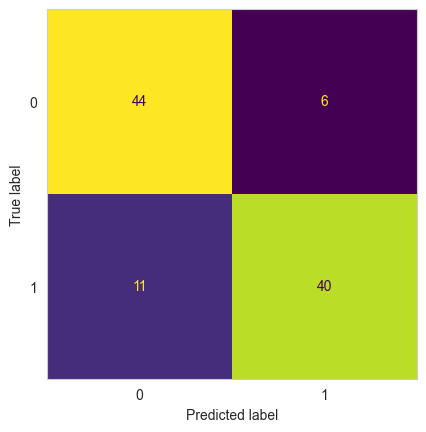

In [17]:
model, _ = svm_model('rbf', predictors_train_mod, response_train_mod, predictors_test_mod, response_test_mod) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test_mod, response_test_mod, colorbar=False, cmap='viridis')
plt.grid(False)

### <span style="color:red">Depending on randomization seed, the results show improvement in accuracy and kappa score for the non-linear SVM compared to linear.</span>

## An attempt at feature optimization 

In [19]:
# Forward sequential
accuracies = {}
features = {}
for i in range(1, predictors_train.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i)  # Forward selection process
    sfs.fit(predictors_train, response_train)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train.loc[:, selected_features]
    predictors_test_sfs = predictors_test.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')


With 1 features: Accuracy -- 70.30%, precision: 78.38%, recall: 56.86%, kappa: 0.41
With 2 features: Accuracy -- 78.22%, precision: 79.59%, recall: 76.47%, kappa: 0.56
With 3 features: Accuracy -- 75.25%, precision: 76.00%, recall: 74.51%, kappa: 0.50
With 4 features: Accuracy -- 75.25%, precision: 76.00%, recall: 74.51%, kappa: 0.50
With 5 features: Accuracy -- 76.24%, precision: 76.47%, recall: 76.47%, kappa: 0.52
With 6 features: Accuracy -- 76.24%, precision: 76.47%, recall: 76.47%, kappa: 0.52
With 7 features: Accuracy -- 75.25%, precision: 76.00%, recall: 74.51%, kappa: 0.50
With 8 features: Accuracy -- 74.26%, precision: 75.51%, recall: 72.55%, kappa: 0.49
With 9 features: Accuracy -- 75.25%, precision: 77.08%, recall: 72.55%, kappa: 0.51
With 10 features: Accuracy -- 76.24%, precision: 77.55%, recall: 74.51%, kappa: 0.52
With 11 features: Accuracy -- 74.26%, precision: 75.51%, recall: 72.55%, kappa: 0.49
With 12 features: Accuracy -- 75.25%, precision: 78.26%, recall: 70.59%, k

In [20]:
# Backward sequential
accuracies = {}
features = {}
for i in range(1, predictors_train.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')  # Forward selection process
    sfs.fit(predictors_train, response_train)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train.loc[:, selected_features]
    predictors_test_sfs = predictors_test.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

With 1 features: Accuracy -- 70.30%, precision: 78.38%, recall: 56.86%, kappa: 0.41
With 2 features: Accuracy -- 78.22%, precision: 79.59%, recall: 76.47%, kappa: 0.56
With 3 features: Accuracy -- 75.25%, precision: 76.00%, recall: 74.51%, kappa: 0.50
With 4 features: Accuracy -- 77.23%, precision: 80.43%, recall: 72.55%, kappa: 0.54
With 5 features: Accuracy -- 82.18%, precision: 88.37%, recall: 74.51%, kappa: 0.64
With 6 features: Accuracy -- 82.18%, precision: 86.67%, recall: 76.47%, kappa: 0.64
With 7 features: Accuracy -- 82.18%, precision: 86.67%, recall: 76.47%, kappa: 0.64
With 8 features: Accuracy -- 82.18%, precision: 86.67%, recall: 76.47%, kappa: 0.64
With 9 features: Accuracy -- 81.19%, precision: 86.36%, recall: 74.51%, kappa: 0.62
With 10 features: Accuracy -- 80.20%, precision: 86.05%, recall: 72.55%, kappa: 0.60
With 11 features: Accuracy -- 81.19%, precision: 86.36%, recall: 74.51%, kappa: 0.62
With 12 features: Accuracy -- 81.19%, precision: 86.36%, recall: 74.51%, k

In [21]:
# Forward sequential (modified)
accuracies = {}
features = {}
for i in range(1, predictors_train_mod.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i)  # Forward selection process
    sfs.fit(predictors_train_mod, response_train_mod)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train_mod.loc[:, selected_features]
    predictors_test_sfs = predictors_test_mod.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train_mod, predictors_test_sfs, response_test_mod, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

With 1 features: Accuracy -- 70.30%, precision: 78.38%, recall: 56.86%, kappa: 0.41
With 2 features: Accuracy -- 78.22%, precision: 79.59%, recall: 76.47%, kappa: 0.56
With 3 features: Accuracy -- 77.23%, precision: 78.00%, recall: 76.47%, kappa: 0.54
With 4 features: Accuracy -- 79.21%, precision: 81.25%, recall: 76.47%, kappa: 0.58
With 5 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 6 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 7 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 8 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 9 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 10 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 11 features: Accuracy -- 83.17%, precision: 86.96%, recall: 78.43%, kappa: 0.66
With 12 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, k

In [22]:
# Backward sequential (modified)
accuracies = {}
features = {}
for i in range(1, predictors_train_mod.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')  # Forward selection process
    sfs.fit(predictors_train_mod, response_train_mod)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train_mod.loc[:, selected_features]
    predictors_test_sfs = predictors_test_mod.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train_mod, predictors_test_sfs, response_test_mod, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

With 1 features: Accuracy -- 70.30%, precision: 78.38%, recall: 56.86%, kappa: 0.41
With 2 features: Accuracy -- 78.22%, precision: 79.59%, recall: 76.47%, kappa: 0.56
With 3 features: Accuracy -- 77.23%, precision: 78.00%, recall: 76.47%, kappa: 0.54
With 4 features: Accuracy -- 79.21%, precision: 81.25%, recall: 76.47%, kappa: 0.58
With 5 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 6 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 7 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 8 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 9 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 10 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 11 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, kappa: 0.64
With 12 features: Accuracy -- 82.18%, precision: 85.11%, recall: 78.43%, k

### <span style="color:red">We can see that by proactively removing some "redundant" features, we might help the feature selection process when we want to minimize features, but in the process the highest accuracy at max number of features might be lost. Nevertheless, backward selection arrives at the same result for optimizing feature set size without any proactive modification of feature set, so no need to use a pre-selected feature set based on correlation.</span>
#### The best model with the current seed compared with a model having lower number of features:

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'mode_1'],
      dtype='object')
Accuracy: 84.16%
Precision: 88.89%
Recall: 78.43%
Cohen's Kappa Score: 0.68


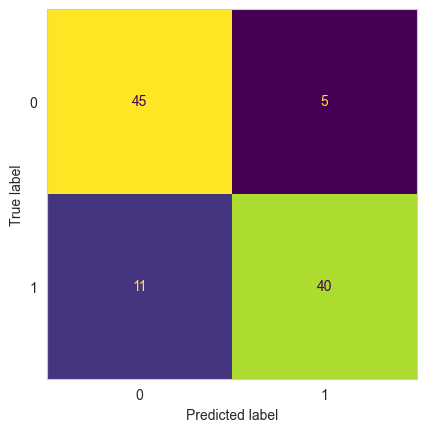

In [24]:
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=20, direction='backward')
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

model, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)

ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
plt.grid(False)

Index(['danceability', 'energy', 'loudness', 'speechiness', 'liveness'], dtype='object')
Accuracy: 82.18%
Precision: 88.37%
Recall: 74.51%
Cohen's Kappa Score: 0.64


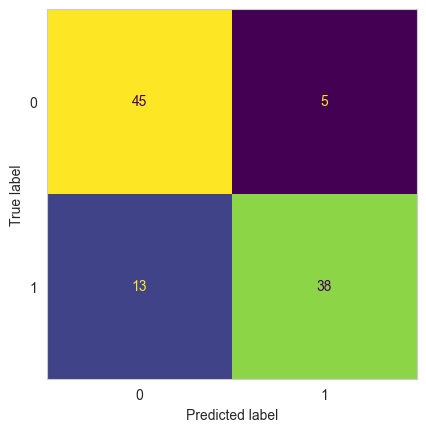

In [25]:
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=5, direction='backward')
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

model, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)

ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
plt.grid(False)

### We can see that the different "key" values play an important role in improving the recall rate of the predictions, i.e. correctly classifying "Like"


# <span style="color:red">Intermediate conclusions</span>

### At this point, I have the following interpretation:
1. The outcome of the model predictions on the test set is *higly!!* dependent on the randomization seed when splitting the data into train/test sets.
2. The combination of logit transform and scaling has a good effect on recall and overall accuracy (did a cross-check separately step-by-step with each pre-processing measure).
3. Checking for correlation among independent variables and proactively removing dependent features might help the feature optimization algorithm (checked with different seeds, got mixed results).
4. Reducing the number of features only marginally reduce accuracy, thus it is highly desired to reduce the number of features to improve generalization and avoid overfitting. 
5. To improve the model, the following needs to be attempted:
    1. adjusting the class weight, i.e. adjusting the weights inversely proportional to class frequency --> class_weight='balanced'
    2. tuning hyperparameters. Increasing the regularization parameter might help, but may also lead to overfitting. Lowering gamma makes the decision boundary simpler which might reduce false positives --> GridSearchCV or RandomizedSearchCV
    3. Adjusting the decision threshold with decision_function() to make the model more conservative in predicting positives.


## Hyperparameter tuning

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'mode_1'],
      dtype='object')
Accuracy: 84.16%
Precision: 88.89%
Recall: 78.43%
Cohen's Kappa Score: 0.68
Regularization parameter (C): 1
Gamma value: 0.12240410786932242


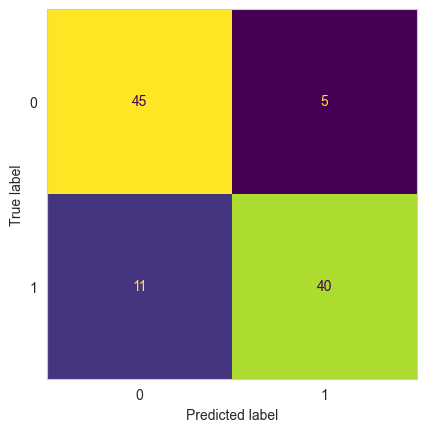

In [28]:
# model with 20 features
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=20, direction='backward')
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

model_best, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)

# Print out the regularization parameter and gamma value
n_features = predictors_train_sfs.shape[1]
X_variance = predictors_train_sfs.var().mean()
gamma_value = 1 / (n_features * X_variance)
print(f"Regularization parameter (C): {model.C}")
print(f"Gamma value: {gamma_value}")
ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
plt.grid(False)

### Accuracy as target

Optimization with cv = 2
Best parameters: {'C': 0.9, 'gamma': 0.05}
Accuracy: 83.17%
Precision: 88.64%
Recall: 76.47%
Cohen's Kappa Score: 0.66


Optimization with cv = 3
Best parameters: {'C': 5.495959595959596, 'gamma': 0.07777777777777778}
Accuracy: 84.16%
Precision: 88.89%
Recall: 78.43%
Cohen's Kappa Score: 0.68


Optimization with cv = 4
Best parameters: {'C': 1.819191919191919, 'gamma': 0.1484848484848485}
Accuracy: 85.15%
Precision: 89.13%
Recall: 80.39%
Cohen's Kappa Score: 0.70


Optimization with cv = 5
Best parameters: {'C': 0.9, 'gamma': 0.05252525252525253}
Accuracy: 83.17%
Precision: 88.64%
Recall: 76.47%
Cohen's Kappa Score: 0.66


Optimization with cv = 6
Best parameters: {'C': 4.668686868686868, 'gamma': 0.05}
Accuracy: 82.18%
Precision: 88.37%
Recall: 74.51%
Cohen's Kappa Score: 0.64


Optimization with cv = 7
Best parameters: {'C': 1.3595959595959597, 'gamma': 0.05}
Accuracy: 81.19%
Precision: 86.36%
Recall: 74.51%
Cohen's Kappa Score: 0.62


C values: {2: 0.9, 3: 5

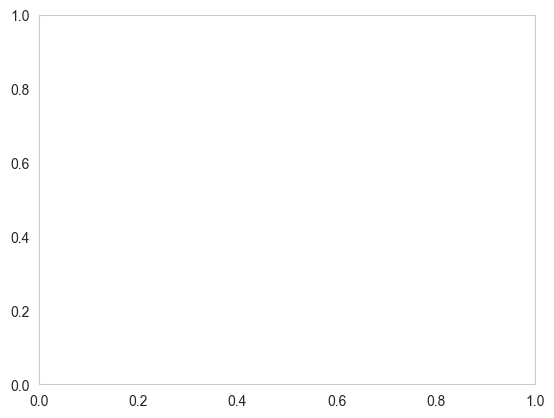

In [31]:
regularization = {}
gamma = {}
# checking different cross-validation split sizes
for i in range(2, 8):
    print(f'Optimization with cv = {i}')
    param_grid = {
        'C': np.linspace(0.9, 10, 100).tolist(),  # Regularization parameter
        'gamma': np.linspace(0.05, 0.3, 100).tolist()  # Kernel coefficient
    }
    
    grid_search = GridSearchCV(model_best, param_grid, scoring='accuracy', n_jobs=-1, cv=i)  # -1 means using all processors in parallel
    grid_search.fit(predictors_train_sfs, response_train)
    
    # Get the best model from the grid search
    best_svm_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    response_pred_rbf_best = best_svm_model.predict(predictors_test_sfs)
    
    # Evaluate the tuning result
    accuracy = accuracy_score(response_test, response_pred_rbf_best)
    precision = precision_score(response_test, response_pred_rbf_best)
    recall = recall_score(response_test, response_pred_rbf_best)
    kappa = cohen_kappa_score(response_test, response_pred_rbf_best)
    
    regularization[i] = grid_search.best_params_['C']
    gamma[i] = grid_search.best_params_['gamma']
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Cohen's Kappa Score: {kappa:.2f}")
    print('\n')
    # ConfusionMatrixDisplay.from_estimator(best_svm_model, predictors_test_sfs, response_test, colorbar=False)
    #plt.grid(False)

print(f'C values: {regularization}')
print(f'gamma values: {gamma}')

#### Note: GridSearchCV uses a 5-fold cross-validation as default to evaluate the different parameter combos. We might have a "lucky" split with the train/test data, hence checking with different cv values to check how the optimum hyperparameters converge.

#### <span style="color:red">We can see that the C value is always between 1 and 5.5, gamma is happy between 0.05 - 0.15. These are not very different and rather inconclusive compared to the initial values of C=1, gamma=0.12.</span>
 
### Attempting to find a trend of best 15 feature set by varying seed.

In [ ]:
for i in range(50):
    print(f'i = {i}')
    predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=i)  # increasing test size
    
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=15, direction='backward')
    sfs.fit(predictors_train, response_train)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train.loc[:, selected_features]
    predictors_test_sfs = predictors_test.loc[:, selected_features]
    print(predictors_test_sfs.columns)
    
    model, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)
    
    ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
    plt.grid(False)